# Paper Code

This jupyter notebook provides all code in the JSS paper and all code required to reproduce the timings and graphs in the paper.

## Code for Graphs

### Chkrebtii Example

In [ ]:
"""
Python file for the sole purpose of producing the graphs in the README file.
"""
import numpy as np
from math import sin, cos
import matplotlib.pyplot as plt

from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad
from euler_approx import euler_approx

# Example ODE Exact Solution for x_t^{(0)}
def ode_exact_x(t):
    return (-3*cos(t) + 2*sin(t) - sin(2*t))/3

# Example ODE Exact Solution for x_t^{(1)}
def ode_exact_x1(t):
    return (-2*cos(2*t) + 3*sin(t) + 2*cos(t))/3

# Example ode written for Euler Approximation
def ode_euler(x,t):
    return np.array([x[1], sin(2*t) -x[0]])

# Helper function to draw samples from Kalman solver
def readme_kalman_draw(fun, n_deriv, n_deriv_prior, n_eval, tmin, tmax, sigma, w_mat, init, draws):
    dt = (tmax-tmin)/n_eval
    X = np.zeros((draws, n_eval+1, sum(n_deriv_prior)))
    W = zero_pad(w_mat, n_deriv, n_deriv_prior)
    x0_state = zero_pad(init, n_deriv, n_deriv_prior)
    prior = ibm_init(dt, n_deriv_prior, sigma)
    kalmanode = KalmanODE(W, tmin, tmax, n_eval, fun, **prior)
    for i in range(draws):
        X[i]= kalmanode.solve_sim(x0_state, W)
        del kalmanode.z_state
    return X

def readme_kalman_mv(fun, n_deriv, n_deriv_prior, n_eval, tmin, tmax, sigma, w_mat, init):
    dt = (tmax-tmin)/n_eval
    W = zero_pad(w_mat, n_deriv, n_deriv_prior)
    x0_state = zero_pad(init, n_deriv, n_deriv_prior)
    prior = ibm_init(dt, n_deriv_prior, sigma)
    kalmanode = KalmanODE(W, tmin, tmax, n_eval, fun, **prior)
    X = kalmanode.solve_mv(x0_state, W)[0]
    return X

def readme_solve(fun, n_deriv, n_deriv_prior, tmin, tmax, n_eval, w_mat, sigma, init, draws):
    """
    Calculates kalman_ode, euler_ode, and exact_ode on the given grid for the README ode.

    Args:
        fun (function): Higher order ODE function :math:`w x_t = F(x_t, t)` 
            taking arguments :math:`x` and :math:`t`.
        n_deriv (list(n_var)): Dimensions of the ODE function.
        n_deriv_prior (list(n_var): Dimensions of the CAR(p) process.
        n_obs (int): Size of the observed state.
        tmin (float): First time point of the time interval to be evaluated; :math:`a`.
        tmax (float): Last time point of the time interval to be evaluated; :math:`b`.
        n_eval (int): Number of discretization points of the time interval that is evaluated, 
            such that discretization timestep is :math:`dt = (b-a)/N`.
        w_mat (ndarray(n_var, q+1)): Corresponds to the :math:`W` matrix in the ODE equation.
        sigma (float): Scale parameter.
        init (ndarray(q+1)) or (ndarray(p)): The initial values of :math:`x_L` or :math:`X_L = (x_L, y_L)`.
        draws (int): Number of samples we need to draw from the kalman solver.
    Returns:
        (tuple):
        - **tseq** (ndarray(n_eval+1)): Time discretization points for :math:`t = 0,1/N,\ldots,1`.
        - **Xt** (ndarray(draws, n_eval+1, n_deriv)): Draws of the solution process :math:`X_t` at times
          :math:`t = 0,1/N,\ldots,1`.
        - **x_euler** (ndarray(n_eval+1, 2)): Euler approximation of the solution process at
          times :math:`t = 0,1/N,\ldots,1`.
        - **x_exact** (ndarray(n_eval+1, 2)): Exact solution at times :math:`t = 0,1/N,\ldots,1`.

    """
    tseq = np.linspace(tmin, tmax, n_eval+1)
    Xt = readme_kalman_draw(fun, n_deriv, n_deriv_prior, n_eval, tmin, tmax, sigma, w_mat, init, draws)
    Xm = readme_kalman_mv(fun, n_deriv, n_deriv_prior, n_eval, tmin, tmax, sigma, w_mat, init)
    x_euler = euler_approx(ode_euler, tseq, init)
    x_exact = np.zeros((n_eval+1, 2))
    for i,t in enumerate(tseq):
        x_exact[i, 0] = ode_exact_x(t)
        x_exact[i, 1] = ode_exact_x1(t)

    return tseq, Xt, x_euler, x_exact, Xm

# Function that produces the graph as shown in README
def readme_graph(fun, n_deriv, n_deriv_prior, tmin, tmax, w_mat, init, draws):
    """
    Produces the graph in README file.

    Args:
        fun (function) : Higher order ODE function :math:`W x_t = F(x_t, t)` 
            taking arguments :math:`x` and :math:`t`.
        n_deriv (list(n_var)): Dimensions of the ODE function.
        n_deriv_prior (list(n_var): Dimensions of the CAR(p) process.
        n_obs (int) : Size of the observed state.
        tmin (float) : First time point of the time interval to be evaluated; :math:`a`.
        tmax (float) : Last time point of the time interval to be evaluated; :math:`b`.
        w_mat (ndarray(n_var, q+1)) : Corresponds to the :math:`W` matrix in the ODE equation.
        init (ndarray(q+1)) or (ndarray(p)): The initial values of :math:`x_L` or :math:`X_L = (x_L, y_L)`.
        draws (int): Number of samples we need to draw from the kalman solver.
    
    """
    # Initialize variables for the graph
    dim_deriv = w_mat.shape[1] - 1
    N = [50, 100, 200]
    Sigma = [[.5], [.05], [.001]]
    dim_example = len(N)
    tseq = [None] * dim_example
    Xn = [None] * dim_example
    Xmean = [None] * dim_example
    x_euler = [None] * dim_example
    x_exact = [None] * dim_example

    for i in range(dim_example):
        tseq[i], Xn[i], x_euler[i], x_exact[i], Xmean[i] = readme_solve(fun=fun,
                                                                        n_deriv=n_deriv,
                                                                        n_deriv_prior=n_deriv_prior, 
                                                                        tmin=tmin, 
                                                                        tmax=tmax, 
                                                                        n_eval=N[i],
                                                                        w_mat=w_mat,
                                                                        sigma=Sigma[i], 
                                                                        init=init,
                                                                        draws=draws)

    fig, axs = plt.subplots(dim_deriv, dim_example, figsize=(20, 10))
    for prow in range(dim_deriv):
        for pcol in range(dim_example):
            # plot Kalman draws
            for i in range(draws):
                if i == (draws - 1):
                    axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,prow], 
                                        color="lightgray", alpha=.3, label="rodeo draws")
                else:
                    axs[prow, pcol].plot(tseq[pcol], Xn[pcol][i,:,prow], 
                                        color="lightgray", alpha=.3)
            # plot Euler and Exact
            axs[prow, pcol].plot(tseq[pcol], x_euler[pcol][:,prow], 
                                label="Euler")
            axs[prow, pcol].plot(tseq[pcol], x_exact[pcol][:,prow], 
                                label="Exact")
            # plot Kalman mean
            axs[prow, pcol].plot(tseq[pcol], Xmean[pcol][:,prow],
                                 label="rodeo mean")
            # set legend and title
            axs[prow, pcol].set_title("$x^{(%s)}_t$;   $N=%s$" % (prow, N[pcol]))
            #axs[prow, pcol].set_ylabel("$x^{(%s)}_t$" % (prow))
    axs[0, -1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    
    fig.tight_layout()
    plt.show()
    return fig


In [ ]:
"""
.. module:: euler_approx

Uses the Euler approximation for univariate ordinary differential equations (ODEs).

"""
import numpy as np

def euler_approx(fun, tseq, x_init):
    """
    Uses the Euler approximation for univariate ordinary differential equations (ODEs).

    Parameters
    ----------
    fun : function 
        ODE function :math:`w' x_t = F(x_t, t)` taking arguments :math:`x` and :math:`t`.
    x_init : ndarray(n_dim_ode)
        The initial value of the IVP problem. 
    tseq : ndarray(n_dim_time)
        Time points to evaluate the Euler approximation.

    Returns
    euler_x : ndarray(n_dim_time, n_dim_ode)
        Approximation of the solution at each time point in tseq.

    """
    h = tseq[1] - tseq[0]
    euler_x = np.zeros((len(tseq), len(x_init)-1))
    euler_x[0] = x_init[0:-1]
    for t in range(len(tseq)-1):
        euler_x[t+1] = euler_x[t] + h*fun(euler_x[t], tseq[t])
    return euler_x
    

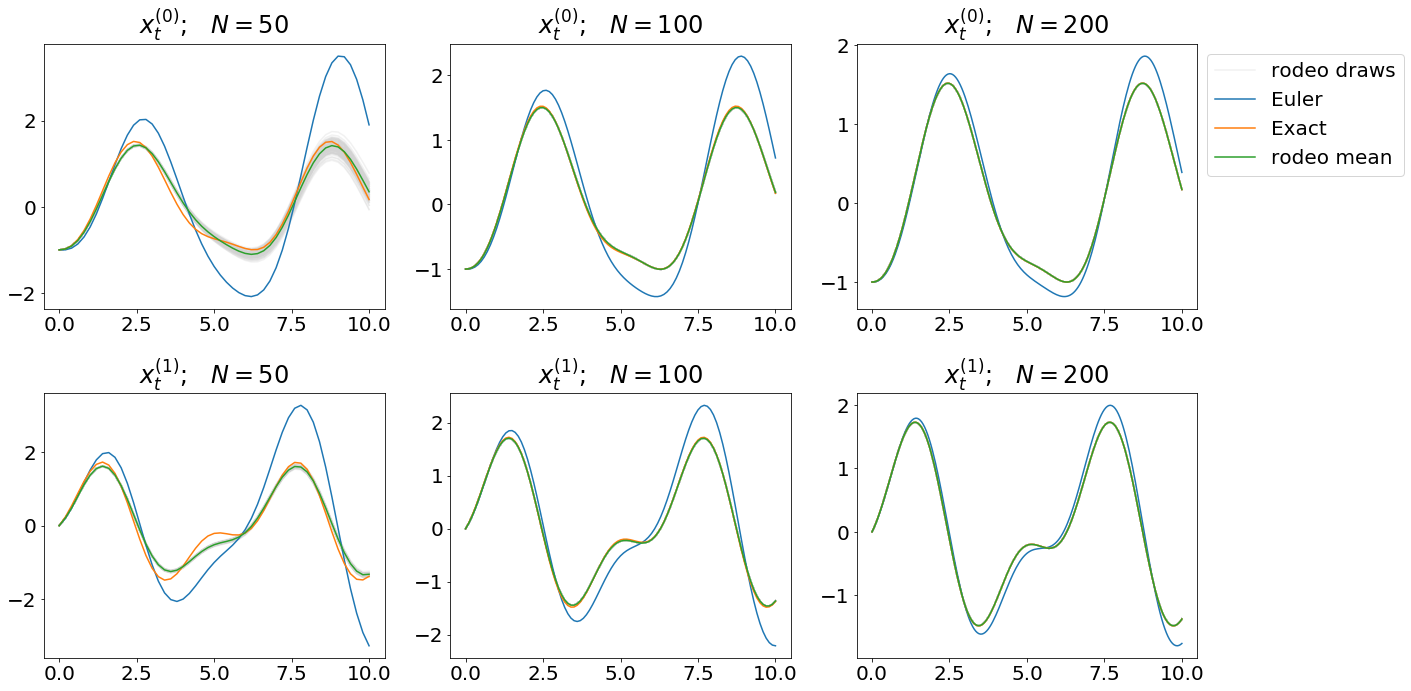

In [1]:
import numpy as np
from math import sin
import matplotlib.pyplot as plt
%matplotlib inline

from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad
from readme_graph import readme_graph

# ODE function
def ode_fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.empty(1)
    x_out[0] = sin(2*t) - x[0]
    return

def chkrebtii_example():
    r"Produces the graph in Figure 1 of the paper."
    # LHS vector of ODE
    # 2.  Define the IVP

    # ODE function
    def ode_fun(x, t, theta=None, x_out=None):
        if x_out is None:
            x_out = np.empty(1)
        x_out[0] = sin(2*t) - x[0]
        return

    W = np.array([[0.0, 0.0, 1.0]])  # LHS vector of ODE
    x0 = np.array([-1., 0., 1.])  # initial value for the IVP

    # Time interval on which a solution is sought.
    tmin = 0
    tmax = 10

    # 3.  Define the prior process
    #
    # (Perhaps best to describe this in text, not code comments)
    #
    # We're going to use a solution prior that has one more derivative than as specified in the IVP.  
    # To do this, we'll pad the original IVP with zeros, for which we have the convenience function 
    # zero_pad().

    n_deriv = [2]  # number of derivatives in IVP
    n_deriv_prior = [4]  # number of derivatives in IBM prior

    # zero padding
    W_pad = zero_pad(W, n_deriv, n_deriv_prior)
    x0_pad = zero_pad(x0, n_deriv, n_deriv_prior)

    # IBM process scale factor
    sigma = [.5]

    # 4.  Instantiate the ODE solver object.

    n_points = 80  # number of steps in which to discretize the time interval.
    dt = (tmax-tmin)/n_points  # step size

    # generate the Kalman parameters corresponding to the prior
    prior = ibm_init(dt, n_deriv_prior, sigma)

    # instantiate the ODE solver
    ode = KalmanODE(W=W_pad,
                    tmin=tmin,
                    tmax=tmax,
                    n_eval=n_points,
                    ode_fun=ode_fun,
                    **prior)


    # 5.  Evaluate the ODE solution

    # deterministic output: posterior mean
    mut, Sigmat = ode.solve_mv(x0=x0_pad)

    # probabilistic output: draw from posterior
    xt = ode.solve_sim(x0=x0_pad)
    
    # Produces the graph in Figure 1
    # set font size
    plt.rcParams.update({'font.size': 20})
    draws = 100
    figure = readme_graph(ode_fun, n_deriv, n_deriv_prior, tmin, tmax, W, x0, draws)
    figure.savefig('figures/chkrebtiifigure.pdf')
    #plt.show()
    return

if __name__ == '__main__':
    chkrebtii_example()
    

### Lorenz Example

In [38]:
"""
.. module:: lorenz_graph

Python file for the sole purpose of producing the graphs in the Lorenz63 example.

"""
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

from rodeo.car import car_init
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def lorenz_graph(fun, n_deriv, n_deriv_prior, tmin, tmax, n_eval, w_mat, tau, sigma, init, theta, draws, method="rodeo", load_calcs=False):
    r"""
    Produces the graph for the Lorenz63 example in tutorial.

    Args:
        fun (function) : Higher order ODE function :math:`W x_t = F(x_t, t)` 
            taking arguments :math:`x` and :math:`t`.
        n_deriv (ndarray(3)) : Number of derivatives per variable in IVP.
        n_deriv_prior (ndarray(3)) : Number of derivatives per variable in prior.
        n_obs (int) : Size of the observed state.
        tmin (float) : First time point of the time interval to be evaluated; :math:`a`.
        tmax (float) : Last time point of the time interval to be evaluated; :math:`b`.
        n_eval (int) : Number of discretization points of the time interval that is evaluated, 
            such that discretization timestep is :math:`dt = (b-a)/N`.
        w_mat (ndarray(q+1)) : Corresponds to the :math:`W` matrix in the ODE equation.
        n_deriv_var (ndarray(3)) : State size of each variable.
        tau (ndarray(3)) : Decorrelation time.
        sigma (ndarray(3)) : Scale parameter.
        init (ndarray(q)) : The initial values of the ode function.
        theta (ndarray(3)) : Specific :math:`\theta` for the Lorenz system.
        draws (int) : Number of samples we need to draw from the kalman solver.
        method (string) : Interrogation method.

    """
    tseq = np.linspace(tmin, tmax, n_eval+1)
    exact = odeint(fun, init[:, 0], tseq, args=(theta, ))
    init = np.ravel([init[:, 0], init[:, 1]], order='F')
    ylabel = ['x', 'y', 'z']
    n_var = len(ylabel)
    dt = (tmax-tmin)/n_eval
    p = sum(n_deriv_prior)

    if load_calcs:
        Xn = np.load(('saves/lorenz{}.npy').format(method))
    else:
        Xn = np.zeros((draws, n_eval+1, p))
        W = zero_pad(w_mat, n_deriv, n_deriv_prior)
        v_init = zero_pad(init, n_deriv, n_deriv_prior)
        ode_init = ibm_init(dt, n_deriv_prior, sigma)
        kinit = indep_init(ode_init, n_deriv_prior)
        kalmanode = KalmanODE(W, tmin, tmax, n_eval, fun, **kinit)
        for i in range(draws):
            Xn[i] = kalmanode.solve_sim(v_init, theta=theta, method=method)
            del kalmanode.z_state
        if method=="rodeo":
            Xmean = kalmanode.solve_mv(v_init, theta=theta, method=method)[0]
            Xmean = np.array([Xmean])
            Xn = np.concatenate([Xn, Xmean])
        np.save(('saves/lorenz{}.npy').format(method), Xn)
    
    fig, axs = plt.subplots(n_var, 1, figsize=(20, 10))
    for prow in range(n_var):
        for i in range(draws):
            if i == (draws - 1):
                axs[prow].plot(tseq, Xn[i, :, sum(n_deriv_prior[:prow])],
                        color="gray", alpha=1, label="rodeo draws")
                axs[prow].set_ylabel(ylabel[prow])
            else:
                axs[prow].plot(tseq, Xn[i, :, sum(n_deriv_prior[:prow])],
                        color="gray", alpha=1)
                
        axs[prow].plot(tseq, exact[:, prow], label='odeint', color="orange")
        if method=="rodeo":
            axs[prow].plot(tseq, Xn[-1, :, sum(n_deriv_prior[:prow])],
                           label="rodeo mean", color="green")
    axs[0].legend(loc='upper left', bbox_to_anchor=[1, 1])
    fig.tight_layout()
    fig.set_rasterized(True)
    plt.show()
    return fig


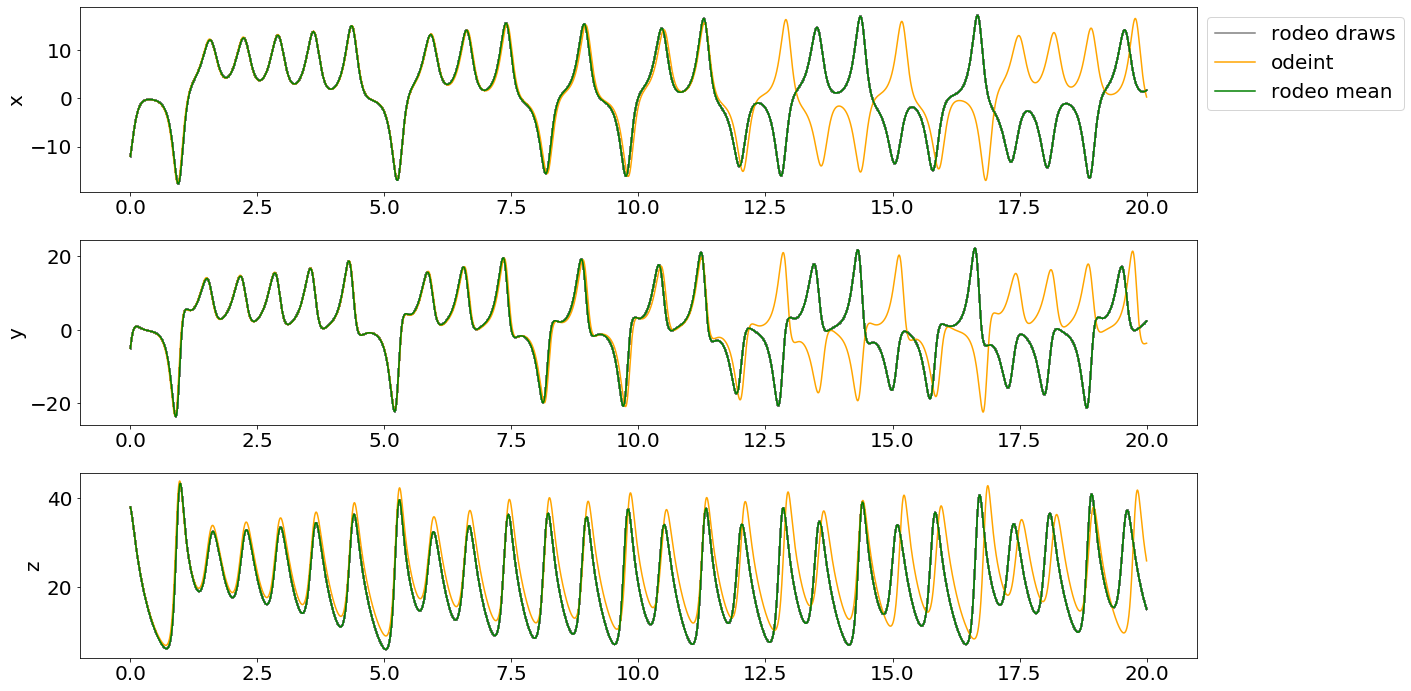

In [39]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from rodeo.car import car_init
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad
#from lorenz_graph import lorenz_graph

# RHS of ODE
def lorenz(X, t, theta, out=None):
    if out is None:
        out = np.empty(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return out

def lorenz_example(load_calcs=False):
    r"Produces the graph in Figure 2 of the paper."

    # theta for this example
    theta = np.array([28, 10, 8/3])

    # Initial value, x0, for the IVP
    x0 = [-12, -5, 38]
    v0 = [70, 125, -124/3]
    X0 = np.column_stack([x0, v0])
    init = np.ravel([X0[:, 0], X0[:, 1]], order='F')
    # prior process definition
    n_deriv = [1, 1, 1] # number of derivatives in IVP
    n_deriv_prior = [3, 3, 3] # number of derivatives in IBM prior

    # LHS Matrix of ODE
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1

    # Time interval on which a solution is sought.
    tmin = 0
    tmax = 20

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    tau = np.array([1.3, 1.3, 1.3])
    sigma = np.array([.1, .1, .1])

    n_points = 5000 # number of steps in which to discretize the time interval.
    
    # Produce the graph in Figure 2
    # set font size
    plt.rcParams.update({'font.size': 20})
    draws = 1000
    method = "rodeo"
    figure = lorenz_graph(lorenz, n_deriv, n_deriv_prior, tmin, tmax, n_points, W_mat, tau, sigma, X0, theta, draws, method, load_calcs)
    figure.tight_layout()
    figure.savefig('figures/lorenzfigure.pdf')
    
    method = "chkrebtii"
    figure = lorenz_graph(lorenz, n_deriv, n_deriv_prior, tmin, tmax, n_points, W_mat, tau, sigma, X0, theta, draws, method, load_calcs)
    figure.tight_layout()
    figure.savefig('figures/lorenzfigure2.pdf')
    
    return

if __name__ == '__main__':
    lorenz_example(True)


### Inference Helper Function

In [1]:
from scipy.integrate import odeint
import numpy as np
import scipy as sp
import scipy.stats
import numdifftools as nd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

import warnings
warnings.filterwarnings('ignore')

class inference:
    r"""
    Perform parameter inference for the model via mode/quadrature using Euler's 
    approximation and the KalmanODE solver. 

    Args:
        state_ind (list): Index of the 0th derivative, :math:`x^{(0)}` of each state.
        tmin (int): First time point of the time interval to be evaluated; :math:`a`.
        tmax (int): Last time point of the time interval to be evaluated; :math:`b`.
        fun (function): Higher order ODE function :math:`W x_t = F(x_t, t)` taking 
            arguments :math:`x` and :math:`t`.
        kode (object): KalmanODE solver used to perform parameter inference.
        x0 (ndarray(n_state)): Initial value of the state variable :math:`x_t` at 
            time :math:`t = 0`.
        theta_true (ndarray(n_theta)): True value of :math:`\theta` in the ODE function.
        gamma (float): Noise parameter to simulate the observations.
        phi (ndarray(n_theta)): Log of observed :math:`\theta`.
        Y_t (ndarray(n_steps, n_state)): Simulated observations.
        step_size (float): Distance between discretisation points.
        phi_mean (ndarray(n_theta)): Mean of :math:`\phi`.
        phi_sd (ndarray(n_theta)): Standard deviation of :math:`\phi`.
        theta (ndarray(n_theta)): Observed :math:`\theta`.
        kalman (bool): Flag to indicate if the KalmanODE solver or Euler's method 
            is used.
        phi_hat (ndarray(n_theta)): Optimized observed :math:`\phi`.
        phi_var (ndarray(n_theta, n_theta)): Variance matrix of phi_hat.
        n_samples (int): Number of samples of :math:`\theta` to simulate.
        theta_euler (ndarray(n_samples, n_theta)): Simulated n_samples of 
            :math:`\theta` using Euler's approximation.
        theta_kalman (ndarray(n_samples, n_theta)): Simulated n_samples of 
            :math:`\theta` using KalmanODE solver.
    """
    def __init__(self, state_ind, tmin, tmax, fun, W=None, kode=None):
        self.state_ind = state_ind
        self.tmin = tmin
        self.tmax = tmax
        self.fun = fun
        self.W = W
        self.kode = kode
    
    def loglike(self, x, mean, var):
        r"Calculate the loglikelihood of the lognormal distribution."
        return np.sum(sp.stats.norm.logpdf(x=x, loc=mean, scale=var))
    
    def simulate(self, fun, x0, theta_true, gamma):
        r"Simulate observed data for inference"
        tseq = np.linspace(self.tmin, self.tmax, self.tmax-self.tmin+1)
        X_t = odeint(fun, x0, tseq, args=(theta_true,))[1:,]
        e_t = np.random.default_rng().normal(loc=0.0, scale=1, size=X_t.shape)
        Y_t = X_t + gamma*e_t
        return Y_t, X_t

    def thinning(self, data_tseq, ode_tseq, X):
        r"Thin a highly discretized ODE solution to match the observed data."
        data_i = 0
        ode_i = 0
        diff = 1000
        ind = np.zeros(len(data_tseq), dtype=int)
        while data_i < len(data_tseq) and ode_i < len(ode_tseq):
            if data_tseq[data_i] > ode_tseq[ode_i]:
                diff = min(diff, abs(data_tseq[data_i] - ode_tseq[ode_i]))
                ode_i+=1
            else:
                if diff > abs(data_tseq[data_i] - ode_tseq[ode_i]):
                    ind[data_i] = ode_i
                else:
                    ind[data_i] = ode_i-1
                data_i+=1
                diff = 1000
        return X[ind,:]

    def kalman_nlpost(self, phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
        r"Compute the negative loglikihood of :math:`Y_t` using the Euler method."
        theta = np.exp(phi)
        data_tseq = np.linspace(1, self.tmax, self.tmax-self.tmin)
        ode_tseq = np.linspace(self.tmin, self.tmax, int((self.tmax-self.tmin)/step_size)+1)
        X_t = self.kode.solve_sim(x0, self.W, theta)
        X_t = self.thinning(data_tseq, ode_tseq, X_t)[:, self.state_ind]
        lp = self.loglike(Y_t, X_t, gamma)
        lp += self.loglike(phi, phi_mean, phi_sd)
        return -lp
        
    def euler(self, x0, step_size, theta):
        r"Evaluate Euler approximation given :math:`\theta`"
        n_eval = int((self.tmax-self.tmin)/step_size)
        data_tseq = np.linspace(1, self.tmax, self.tmax-self.tmin)
        ode_tseq = np.linspace(self.tmin, self.tmax, n_eval+1)
        X_t = np.zeros((n_eval+1, len(x0)))
        X_t[0] = x0
        for i in range(n_eval):
            self.fun(X_t[i], step_size*i, theta, X_t[i+1])
            X_t[i+1] = X_t[i] + X_t[i+1]*step_size
        X_t = self.thinning(data_tseq, ode_tseq, X_t)
        return X_t
    
    def euler_nlpost(self, phi, Y_t, x0, step_size, phi_mean, phi_sd, gamma):
        r"Compute the negative loglikihood of :math:`Y_t` using the Euler method."
        theta = np.exp(phi)
        X_t = self.euler(x0, step_size, theta)
        lp = self.loglike(Y_t, X_t, gamma)
        lp += self.loglike(phi, phi_mean, phi_sd)
        return -lp
    
    def phi_fit(self, Y_t, x0, step_size, theta_true, phi_sd, gamma, kalman):
        r"""Compute the optimized :math:`\log{\theta}` and its variance given 
            :math:`Y_t`."""
        phi_mean = np.log(theta_true)
        n_theta = len(theta_true)
        if kalman:
            obj_fun = self.kalman_nlpost
        else:
            obj_fun = self.euler_nlpost
        opt_res = sp.optimize.minimize(obj_fun, phi_mean+.1,
                                    args=(Y_t, x0, step_size, phi_mean, phi_sd, gamma),
                                    method='Nelder-Mead')
        phi_hat = opt_res.x
        hes = nd.Hessian(obj_fun)
        phi_fisher = hes(phi_hat, Y_t, x0, step_size, phi_mean, phi_sd, gamma)
        phi_cho, low = sp.linalg.cho_factor(phi_fisher)
        phi_var = sp.linalg.cho_solve((phi_cho, low), np.eye(n_theta))
        return phi_hat, phi_var
    
    def theta_sample(self, phi_hat, phi_var, n_samples):
        r"""Simulate :math:`\theta` given the :math:`\log{\hat{\theta}}` 
            and its variance."""
        phi = np.random.multivariate_normal(phi_hat, phi_var, n_samples)
        theta = np.exp(phi)
        return theta
    
    def theta_plot(self, theta_euler, theta_kalman, theta_true, step_sizes, rows=1):
        r"""Plot the distribution of :math:`\theta` using the Kalman solver 
            and the Euler approximation."""
        n_size, _, n_theta = theta_euler.shape
        n_theta = n_theta//rows
        nrow = 2
        fig, axs = plt.subplots(rows*nrow, n_theta, figsize=(20, 5*rows))
        patches = [None]*(n_size+1)
        for r in range(rows):
            for col in range(n_theta):
                axs[nrow*r, col].set_title('$\\theta_{}$'.format(r*n_theta+col))
                for row in range(nrow):
                    axs[nrow*r+row, col].axvline(x=theta_true[r*n_theta+col], linewidth=1, color='r', linestyle='dashed')
                    axs[nrow*r+row, col].locator_params(axis='x', nbins=3)
                    axs[nrow*r+row, col].set_yticks([])
                    if row==1:
                        axs[nrow*r+row, col].get_shared_x_axes().join(axs[nrow*r+row, col], axs[nrow*r, col])
                for i in range(n_size):
                    if col==0:
                        patches[i] = mpatches.Patch(color='C{}'.format(i), label='h={}'.format(step_sizes[i]))
                    sns.kdeplot(theta_euler[i, :, r*n_theta+col], ax=axs[nrow*r, col])
                    sns.kdeplot(theta_kalman[i, :, r*n_theta+col], ax=axs[nrow*r+1, col])

        for r in range(nrow*rows):
            if r%2==0:
                axs[r, 0].set_ylabel('Euler')
            else:
                axs[r, 0].set_ylabel('rodeo')
        patches[-1] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\theta$')
        axs[0, -1].legend(handles=patches, framealpha=0.5)
        fig.tight_layout()
        plt.show()
        return fig

### Fitz Example

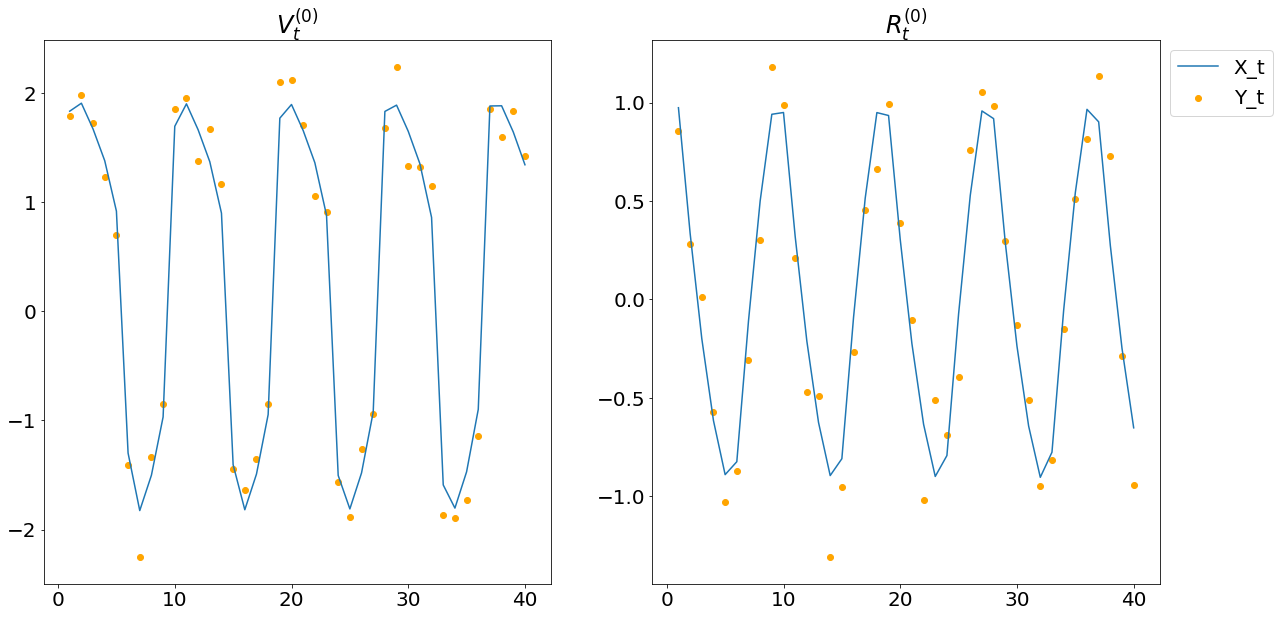

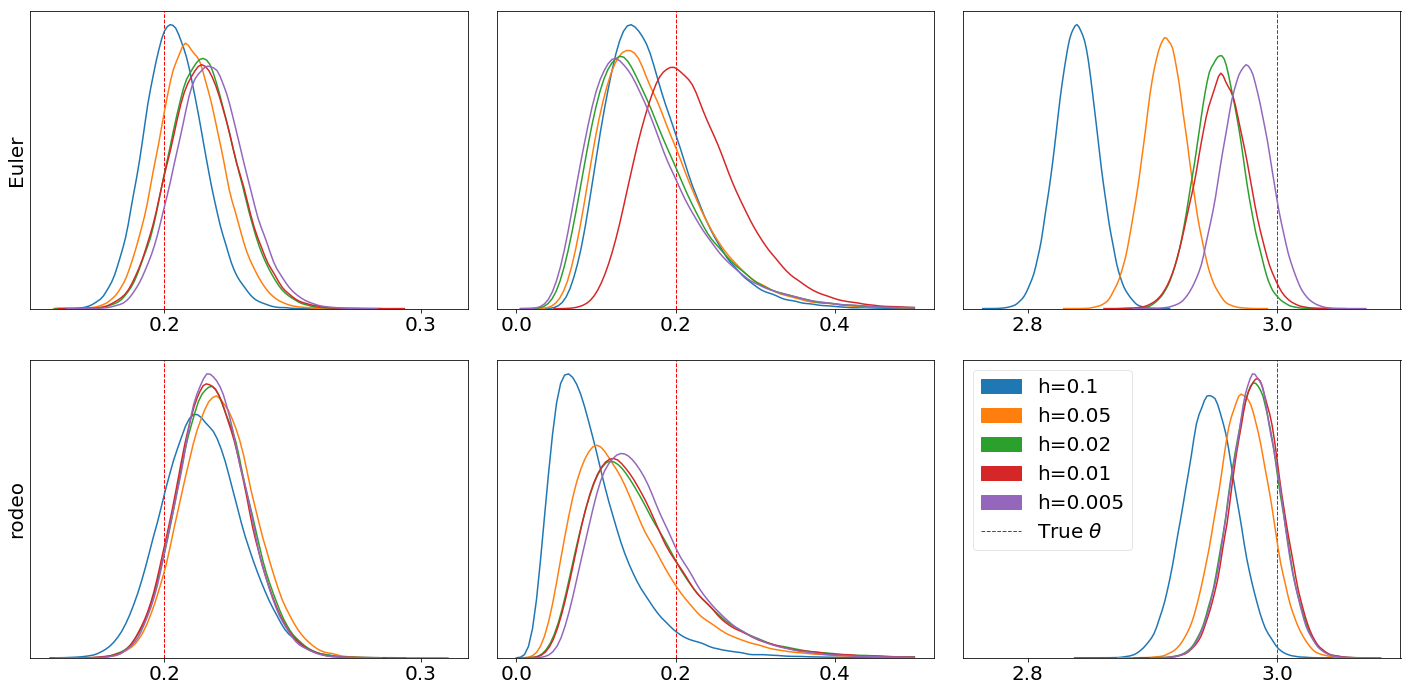

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from inference import inference
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def fitz(X_t, t, theta, out=None):
    "FN ODE function with optional overwriting of output."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

def fitz_example(load_calcs=False):
    "Perform parameter inference using the FitzHugh-Nagumo function."
    # These parameters define the order of the ODE and the CAR(p) process
    n_deriv = [1, 1] # Total state
    n_obs = 2 # Total measures
    n_deriv_prior = [3, 3]
    p = sum(n_deriv_prior)
    state_ind = [0, 3] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0 
    tmax = 40

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 2
    sigma = [.1]*n_var

    # Initial value, x0, for the IVP
    x0 = np.array([-1., 1.])
    v0 = np.array([1, 1/3])
    X0 = np.ravel([x0, v0], 'F')

    # pad the inputs
    w_mat = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]])
    W = zero_pad(w_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    theta_true = np.array([0.2, 0.2, 3]) # True theta
    n_theta = len(theta_true)
    phi_sd = np.ones(n_theta) 

    # Observation noise
    gamma = 0.2

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, fitz)
    Y_t, X_t = inf.simulate(fitz, x0, theta_true, gamma)
    tseq = np.linspace(1, tmax, 40)
    plt.rcParams.update({'font.size': 20})
    fig, axs = plt.subplots(1, 2, figsize=(20, 10))
    axs[0].plot(tseq, X_t[:,0], label = 'X_t')
    axs[0].scatter(tseq, Y_t[:,0], label = 'Y_t', color='orange')
    axs[0].set_title("$V^{(0)}_t$")
    axs[1].plot(tseq, X_t[:,1], label = 'X_t')
    axs[1].scatter(tseq, Y_t[:,1], label = 'Y_t', color='orange')
    axs[1].set_title("$R^{(0)}_t$")
    axs[1].legend(loc='upper left', bbox_to_anchor=[1, 1])
    fig.savefig('figures/fitzsim.pdf')
    
    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    if load_calcs:
        theta_euler = np.load('saves/fitz_theta_euler.npy')
        theta_kalman = np.load('saves/fitz_theta_kalman2.npy')
    else:
        # Parameter inference using Euler's approximation
        theta_euler = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
            theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/fitz_theta_euler.npy', theta_euler)
        
        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            print(hlst[i])
            ode_init = ibm_init(hlst[i], n_deriv_prior, sigma)
            x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
            kinit = indep_init(ode_init, n_deriv_prior)
            n_eval = int((tmax-tmin)/hlst[i])
            kode = KalmanODE(W, tmin, tmax, n_eval, fitz, **kinit)
            inf.kode = kode
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
            theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/fitz_theta_kalman2.npy', theta_kalman)
        
    # Produces the graph in Figure 3
    plt.rcParams.update({'font.size': 20})
    figure = inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst, clip=[None, (0, 0.5), None])
    figure.savefig('figures/fitzfigure.pdf')
    return

if __name__ == '__main__':
    fitz_example(True)
    

### MSEIR Example

In [1]:
import numpy as np
from inference import inference
import matplotlib.pyplot as plt
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def mseir(X_t, t, theta, out=None):
    "MSEIR ODE function"
    if out is None:
        out = np.empty(5)
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    out[0] = Lambda - delta*M - mu*M
    out[1] = delta*M - beta*S*I/N - mu*S
    out[2] = beta*S*I/N - (epsilon + mu)*E
    out[3] = epsilon*E - (gamma + mu)*I
    out[4] = gamma*I - mu*R
    return out

def mseir_example(load_calcs=False):
    "Perform parameter inference using the MSEIR function."
    # These parameters define the order of the ODE and the CAR(p) process
    n_deriv = [1]*5 # Total state
    n_deriv_prior= [3]*5
    state_ind = [0, 3, 6, 9, 12] # Index of 0th derivative of each state

    # it is assumed that the solution is sought on the interval [tmin, tmax].
    tmin = 0
    tmax = 40

    # The rest of the parameters can be tuned according to ODE
    # For this problem, we will use
    n_var = 5
    sigma = [.1]*n_var

    # Initial value, x0, for the IVP
    theta_true = (1.1, 0.7, 0.4, 0.005, 0.02, 0.03) # True theta
    x0 = np.array([1000, 100, 50, 3, 3])
    v0 = mseir(x0, 0, theta_true)
    X0 = np.ravel([x0, v0], 'F')

    # W matrix: dimension is n_eq x sum(n_deriv)
    W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
    for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
    W = zero_pad(W_mat, n_deriv, n_deriv_prior)

    # logprior parameters
    n_theta = len(theta_true)
    phi_sd = np.ones(n_theta)

    # Observation noise
    gamma = 0.2

    # Number of samples to draw from posterior
    n_samples = 100000

    # Initialize inference class and simulate observed data
    inf = inference(state_ind, tmin, tmax, mseir)
    Y_t = inf.simulate(mseir, x0, theta_true, gamma)
    
    hlst = np.array([0.1, 0.05, 0.02, 0.01, 0.005])
    if load_calcs:
        theta_euler = np.load('saves/mseir_theta_euler.npy')
        theta_kalman = np.load('saves/mseir_theta_kalman2.npy')
    else:
        # Parameter inference using Euler's approximation
        theta_euler = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            phi_hat, phi_var = inf.phi_fit(Y_t, x0, hlst[i], theta_true, phi_sd, gamma, False)
            theta_euler[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/mseir_theta_euler.npy', theta_euler)

        # Parameter inference using Kalman solver
        theta_kalman = np.zeros((len(hlst), n_samples, n_theta))
        for i in range(len(hlst)):
            ode_init= ibm_init(hlst[i], n_deriv_prior, sigma)
            x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
            kinit = indep_init(ode_init, n_deriv_prior)
            n_eval = int((tmax-tmin)/hlst[i])
            kode = KalmanODE(W, tmin, tmax, n_eval, mseir, **kinit)
            inf.kode = kode
            inf.W = W
            phi_hat, phi_var = inf.phi_fit(Y_t, x0_state, hlst[i], theta_true, phi_sd, gamma, True)
            theta_kalman[i] = inf.theta_sample(phi_hat, phi_var, n_samples)
        np.save('saves/mseir_theta_kalman2.npy', theta_kalman)

    # Produces the graph in Figure 4
    plt.rcParams.update({'font.size': 20})
    figure = inf.theta_plot(theta_euler, theta_kalman, theta_true, hlst, rows=2)
    figure.savefig('figures/mseirfigure.pdf')
    plt.show()
    return

if __name__ == '__main__':
    mseir_example(True)

<Figure size 2000x2000 with 12 Axes>

## Code in Paper

### Chkrebtii Example

In [ ]:
# 1.  Import libraries and module
import numpy as np
from math import sin
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

# 2.  Define the IVP

# ODE function
def ode_fun(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.empty(1)
    x_out[0] = sin(2*t) - x[0]
    return

W = np.array([[0.0, 0.0, 1.0]])  # LHS vector of ODE
x0 = np.array([-1., 0., 1.])  # initial value for the IVP

# Time interval on which a solution is sought.
tmin = 0
tmax = 10

# 3.  Define the prior process

n_deriv = [2]  # number of derivatives in IVP
n_deriv_prior = [4]  # number of derivatives in IBM prior

# zero padding
W_pad = zero_pad(x=W,
                 n_deriv=n_deriv, 
                 n_deriv_prior=n_deriv_prior)
x0_pad = zero_pad(x=x0, 
                  n_deriv=n_deriv,
                  n_deriv_prior=n_deriv_prior)

# IBM process scale factor
sigma = [.5]

# 4.  Instantiate the ODE solver object.
n_eval = 80  # number of steps in which to discretize the time interval.
dt = (tmax-tmin)/n_eval  # step size

# generate the Kalman parameters corresponding to the prior
prior = ibm_init(dt=dt, 
                 n_deriv_prior=n_deriv_prior, 
                 sigma=sigma)

# instantiate the ODE solver
ode = KalmanODE(W=W_pad,
                tmin=tmin,
                tmax=tmax,
                n_eval=n_eval,
                ode_fun=ode_fun,
                **prior)


# 5.  Evaluate the ODE solution

# deterministic output: posterior mean
mut, Sigmat = ode.solve_mv(x0=x0_pad)

# probabilistic output: draw from posterior
xt = ode.solve_sim(x0=x0_pad)


### Lorenz Example

In [ ]:
# 1.  Import libraries and module
import numpy as np
from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

# 2.  Define the IVP

# ODE function
def lorenz(X, t, theta,  out=None):
    if out is None:
        out = np.empty(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y -x*z
    out[2] = -beta*z + x*y
    return out

# theta for this example
theta = np.array([28, 10, 8/3])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
v0 = [70, 125, -124/3]
X0 = np.ravel([x0, v0], 'F')

# 3.  Define the prior process

n_deriv = [1, 1, 1] # number of derivatives in IVP
n_deriv_prior = [3, 3, 3] # number of derivatives in IBM prior

# LHS Matrix of ODE
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1

# zero padding
W_pad = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_pad = zero_pad(X0, n_deriv, n_deriv_prior)

# Time interval on which a solution is sought.
tmin = 0
tmax = 20

# IBM process scale factor
sigma = np.array([.5, .5, .5])

# 4.  Instantiate the ODE solver object.

n_eval = 5000 # number of steps in which to discretize the time interval.
dt = (tmax-tmin)/n_eval # step size

# generate the Kalman parameters corresponding to the prior
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)

# instantiate the ODE solver
ode = KalmanODE(W_pad, tmin, tmax, n_eval, lorenz, **kinit)
# Run the solver to get an approximation


# 5.  Evaluate the ODE solution

# deterministic output: posterior mean
mut, Sigmat = ode.solve_mv(x0=x0_pad, theta=theta)

# probabilistic output: draw from posterior
xt = ode.solve_sim(x0=x0_pad, theta=theta)


### Fitz Example

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
from scipy.integrate import odeint
import numdifftools as nd

from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def fitz(X_t, t, theta, out=None):
    "FitzHugh-Nagumo ODE function."
    if out is None:
        out = np.empty(2)
    a, b, c = theta
    n_deriv1 = len(X_t)//2
    V, R = X_t[0], X_t[n_deriv1]
    out[0] = c*(V - V*V*V/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return out

# true theta
theta = np.array([.2, .2, 3])

# simulate data
tmin = 0
tmax = 40
tseq = np.linspace(tmin, tmax, tmax-tmin+1)
gamma = 0.2
x0 = np.array([-1., 1.])
X_t = odeint(fitz, [-1., 1.], tseq, args=(theta,))[1:,]
Y_t = X_t + gamma*np.random.default_rng().normal(0.0, 1, X_t.shape)

# set up KalmanODE for inference

# number of derivatives (incl. zero) per variable in ODE-IVP
n_deriv = [1, 1]
# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.array([[0., 1., 0., 0.], [0., 0., 0., 1.]], order="F")
# initial value
v0 = fitz(x0, 0, theta)
v_init = np.ravel([x0, v0], 'F')
x0 = np.array([-1., 1.])
X0 = np.array([-1, 1, 1, 1/3])
# prior process definition
# number of derivatives per variable in prior
n_deriv_prior = [3, 3]
# pad the inputs
W_pad = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_pad = zero_pad(v_init, n_deriv, n_deriv_prior)
# parameters independent CAR(p) process per variable
n_var = 2  # number of variables
sigma = [.1]*n_var
h = 0.1 # step size
ode_init = ibm_init(h, n_deriv_prior, sigma)
ode_init = indep_init(ode_init, n_deriv_prior)

# create ODE solver
n_points = int((tmax-tmin)/h)
kode = KalmanODE(W_pad, tmin, tmax, n_points, fitz, **ode_init)

# numerical optimization
def logpost(phi, Y_t, x0_pad, h, phi_mean, phi_sd, gamma, dt=1):
    r"""Calculate the log posterior for optimization. KalmanODE gives a highly
    discretized solution that needs thinning to match the times of the observations. 
    Thinning is done by calculating the number of elements to skip in the discretized
    solution. 

    Args:
        phi (ndarray(n_theta)): Log of the parameters to the ODE function, theta.
        Y_t (ndarray(n_obs, n_var)): Noisy observations.
        x0_pad (ndarray(p)): Zero padded initial values.
        h (float): Discretization size.
        phi_mean (ndarray(n_theta)): Log of the mean of the true theta.
        phi_sd (ndarray(n_theta)): Log of the standard deviation of the true theta.
        gamma (float): Standard deviation of the noise.
        dt (float): Inter-observation step size.
    
    Returns:
        ll (float): Log posterior of the observations.
        
    """
    theta = np.exp(phi)  # parameter conversion
    X_t = kode.solve_sim(x0_pad, theta=theta)
    thin = int(dt/h)
    state_ind = [sum(n_deriv_prior[:i]) for i in range(len(n_deriv_prior))]
    ll = np.sum(sp.stats.norm.logpdf(Y_t, X_t[thin::thin, state_ind], gamma))
    ll += np.sum(sp.stats.norm.logpdf(phi, phi_mean, phi_sd))
    return -ll

n_theta = len(theta)
phi_mean = np.log(theta)
phi_sd = np.ones(n_theta)
phi_init = np.log(np.array([0.1, 0.1, 1]))
opt_res = sp.optimize.minimize(logpost, phi_init,
                            args=(Y_t, x0_pad, h, phi_mean, phi_sd, gamma),
                            method='Nelder-Mead')
phi_hat = opt_res.x

# calculate Hessian
hes = nd.Hessian(logpost)
phi_fisher = hes(phi_hat, Y_t, x0_pad, h, phi_mean, phi_sd, gamma)
phi_cho, low = sp.linalg.cho_factor(phi_fisher)
phi_var = sp.linalg.cho_solve((phi_cho, low), np.eye(n_theta))

# sample from posterior
n_samples = 100000
phi_post = np.random.multivariate_normal(phi_hat, phi_var, n_samples)
theta_post = np.exp(phi_post)

### MSEIR Example

In [ ]:
import numpy as np
import scipy as sp
import scipy.stats
from scipy.integrate import odeint
import numdifftools as nd

from rodeo.ibm import ibm_init
from rodeo.cython.KalmanODE import KalmanODE
from rodeo.utils import indep_init, zero_pad

def mseir(X_t, t, theta, out=None):
    "MSEIR ODE function"
    if out is None:
        out = np.empty(5)
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    out[0] = Lambda - delta*M - mu*M
    out[1] = delta*M - beta*S*I/N - mu*S
    out[2] = beta*S*I/N - (epsilon + mu)*E
    out[3] = epsilon*E - (gamma + mu)*I
    out[4] = gamma*I - mu*R
    return out

# true theta
theta = np.array([1.1, 0.7, 0.4, 0.005, 0.02, 0.03])

# simulate data
tmin = 0
tmax = 40
tseq = np.linspace(tmin, tmax, tmax-tmin+1)
gamma = 0.2 # observation noise
x0 = np.array([1000, 100, 50, 3, 3])
X_t = odeint(mseir, x0, tseq, args=(theta,))[1:,]
Y_t = X_t + gamma*np.random.default_rng().normal(0.0, 1, X_t.shape)

# set up KalmanODE for inference

# number of derivatives (incl. zero) per variable in ODE-IVP
n_var = 5  # number of variables
n_deriv = [1]*n_var
# W matrix: dimension is n_eq x sum(n_deriv)
W_mat = np.zeros((len(n_deriv), sum(n_deriv) + len(n_deriv)))
for i in range(len(n_deriv)): W_mat[i, sum(n_deriv[:i])+i+1] = 1
# initial value
v0 = mseir(x0, 0, theta)
v_init = np.ravel([x0, v0], 'F')

# prior process definition
# number of derivatives per variable in prior
n_deriv_prior = [3]*n_var
# pad the inputs
W_pad = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_pad = zero_pad(v_init, n_deriv, n_deriv_prior)
# parameters independent CAR(p) process per variable
sigma = [.1]*n_var
h = 0.1 # step size
ode_init = ibm_init(h, n_deriv_prior, sigma)
ode_init = indep_init(ode_init, n_deriv_prior)

# create ODE solver
n_points = int((tmax-tmin)/h)
kode = KalmanODE(W_pad, tmin, tmax, n_points, mseir, **ode_init)

# numerical optimization
def logpost(phi, Y_t, x0_pad, h, phi_mean, phi_sd, gamma):
    "Calculate the log posterior for optimization."
    theta = np.exp(phi)  # parameter conversion
    X_t = kode.solve_sim(x0_pad, theta=theta)
    thin = int(1/h)
    state_ind = [sum(n_deriv_prior[:i]) for i in range(len(n_deriv_prior))]
    ll = np.sum(sp.stats.norm.logpdf(Y_t, X_t[thin::thin, state_ind], gamma))
    ll += np.sum(sp.stats.norm.logpdf(phi, phi_mean, phi_sd))
    return -ll

n_theta = len(theta)
phi_mean = np.log(theta)
phi_sd = np.ones(n_theta)
phi_init = phi_mean + 0.1
opt_res = sp.optimize.minimize(logpost, phi_init,
                            args=(Y_t, x0_pad, h, phi_mean, phi_sd, gamma),
                            method='Nelder-Mead')
phi_hat = opt_res.x
# calculate Hessian
hes = nd.Hessian(logpost)
phi_fisher = hes(phi_hat, Y_t, x0_pad, h, phi_mean, phi_sd, gamma)
phi_cho, low = sp.linalg.cho_factor(phi_fisher)
phi_var = sp.linalg.cho_solve((phi_cho, low), np.eye(n_theta))

# sample from posterior
n_samples = 100000
phi_post = np.random.multivariate_normal(phi_hat, phi_var, n_samples)
theta_post = np.exp(phi_post)


## Code for Timings

### Cython Code for ODE Functions

In [ ]:
%%cython 
# cythonized versions of the ODE functions used in the timing benchmarks
import cython
from libc.math cimport sin


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef chkrebtii_fun(double[::1] X, double t, double[::1] theta, double[::1] out):
    """
    Chkrebtii ODE function.
    """
    out[0] = sin(2*t) - X[0]
    return


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef lorenz_fun(double[::1] X, double t, double[::1] theta, double[::1] out):
    """
    Lorenz63 ODE function.
    """
    rho, sigma, beta = theta
    cdef int p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[0] = -sigma*x + sigma*y
    out[1] = rho*x - y - x*z
    out[2] = -beta*z + x*y
    return


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef fitz_fun(double[::1] X, double t, double[::1] theta, double[::1] out):
    """
    FitzHugh-Nagumo ODE function.
    """
    a, b, c = theta
    cdef int p = len(X)//2
    V, R = X[0], X[p]
    out[0] = c*(V - V**3/3 + R)
    out[1] = -1/c*(V - a + b*R)
    return


@cython.boundscheck(False)
@cython.wraparound(False)
cpdef mseir_fun(double[::1] X, double t, double[::1] theta, double[::1] out):
    """
    MSEIR ODE function.
    """
    cdef int p = len(X)//5
    M, S, E, I, R = X[::p]
    cdef double N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    out[0] = Lambda - delta*M - mu*M
    out[1] = delta*M - beta*S*I/N - mu*S
    out[2] = beta*S*I/N - (epsilon + mu)*E
    out[3] = epsilon*E - (gamma + mu)*I
    out[4] = gamma*I - mu*R
    return


### Timing Helper Function

In [ ]:
from timeit import default_timer as timer
from scipy.integrate import odeint


def timing(kalmanode, x0_state, W, theta, n_loops):
    start = timer()
    for i in range(n_loops):
        kalmanode.solve_sim(x0_state, W, theta)
    end = timer()
    return (end - start)/n_loops


def det_timing(f, x0, tseq, n_loops, theta=None):
    start = timer()
    for i in range(n_loops):
        _ = odeint(f, x0, tseq, args=(theta, ))
    end = timer()
    return (end - start)/n_loops


### Chkrebtii Example

In [ ]:
import warnings
import numba
import numpy as np
import getopt
import sys
from numba.core.errors import NumbaPerformanceWarning
from timer import *
from numba import njit
from scipy.integrate import odeint
from math import sin
import sys
sys.path.append("..")
from KalmanODE_py import KalmanODE_py
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.ibm import ibm_init
from rodeo.numba.KalmanODE import KalmanODE as KalmanODE_num
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_cy
from rodeo.eigen.KalmanODE import KalmanODE as KalmanODE_c
from rodeo.eigen.KalmanODE2 import KalmanODE as KalmanODE_c2
from rodeo.tests.ode_functions import chkrebtii_fun as ode_fun_nd
from rodeo.tests.ode_functions_ctuple import chkrebtii_fun as ode_fun_ct

# pick ode function
use_ctuple = False
opts, args = getopt.getopt(sys.argv[1:], "c")
for o, a in opts:
    use_ctuple = o == "-c"

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)


# ode function used by cython, C++, python
# def ode_fun(x, t, theta=None, x_out=None):
#     if x_out is None:
#         x_out = np.zeros(1)
#     x_out[0] = sin(2*t) - x[0]
#     return

# ode function used by numba


@njit
def ode_fun2(x, t, theta=None, x_out=None):
    if x_out is None:
        x_out = np.zeros(1)
    x_out[0] = sin(2*t) - x[0]
    return x_out

# ode function used by odeint (output is different)


@njit
def f(x_t, t, theta=None):
    return [x_t[1], sin(2*t) - x_t[0]]


# problem setup and intialization
# LHS vector of ODE
w_mat = np.array([[0.0, 0.0, 1.0]])

n_deriv = [2]
n_deriv_prior = [4]

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 80
tmin = 0
tmax = 10

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = [.5]

# Initial value, x0, for the IVP
x0 = np.array([-1., 0., 1.])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
# All necessary parameters are in kinit, namely, T, c, R, W
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(x0, n_deriv, n_deriv_prior)
kinit = ibm_init(dt, n_deriv_prior, sigma)
z_state = rand_mat(2*n_eval, sum(n_deriv_prior))
theta = np.empty(0)

# pick ode function with ndarray or ctuple inputs
ode_fun = ode_fun_ct if use_ctuple else ode_fun_nd
if use_ctuple:
    theta = tuple(theta)


# Timings
n_loops = 1000
# C++
kode_c = KalmanODE_c(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c.z_state = z_state
time_c = timing(kode_c, x0_state, W, theta, n_loops)

# C++2
kode_c2 = KalmanODE_c2(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c2.z_state = z_state
time_c2 = timing(kode_c2, x0_state, W, theta, n_loops)

# cython
kode_cy = KalmanODE_cy(W, tmin, tmax, n_eval,
                       ode_fun, **kinit)  # Initialize the class
kode_cy.z_state = z_state
time_cy = timing(kode_cy, x0_state, W, theta, n_loops)

# numba
kode_num = KalmanODE_num(W, tmin, tmax, n_eval, ode_fun2, **kinit, z_state=z_state)
# Need to run once to compile KalmanTV
_ = kode_num.solve_sim(x0_state, W, theta)
time_num = timing(kode_num, x0_state, W, theta, n_loops)

# python
kode_py = KalmanODE_py(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_py.z_state = z_state
time_py = timing(kode_py, x0_state, W, theta, n_loops)

# odeint
tseq = np.linspace(tmin, tmax, n_eval+1)
_ = f(x0[0:2], tseq[0], theta=None)
time_det = det_timing(f, x0[0:2], tseq, n_loops)

print("Cython is {}x faster than Python".format(time_py/time_cy))
print("Numba is {}x faster than Python".format(time_py/time_num))
print("C++ is {}x faster than Python".format(time_py/time_c))
print("C++2 is {}x faster than Python".format(time_py/time_c2))
print("ode is {}x faster than Python".format(time_py/time_det))


### Lorenz Example

In [ ]:
import warnings
import numba
import numpy as np
import getopt
import sys
from numba.core.errors import NumbaPerformanceWarning
from timer import *
from numba import njit
from scipy.integrate import odeint
import sys
sys.path.append("..")
from KalmanODE_py import KalmanODE_py
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.ibm import ibm_init
from rodeo.numba.KalmanODE import KalmanODE as KalmanODE_num
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_cy
from rodeo.eigen.KalmanODE import KalmanODE as KalmanODE_c
from rodeo.eigen.KalmanODE2 import KalmanODE as KalmanODE_c2
from rodeo.tests.ode_functions import lorenz_fun as ode_fun_nd
from rodeo.tests.ode_functions_ctuple import lorenz_fun as ode_fun_ct

# pick ode function
use_ctuple = False
opts, args = getopt.getopt(sys.argv[1:], "c")
for o, a in opts:
    use_ctuple = o == "-c"

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)


# ode function used by cython, C++, python

# def ode_fun(X, t, theta, out):
#     rho, sigma, beta = theta
#     p = len(X)//3
#     x, y, z = X[p*0], X[p*1], X[p*2]
#     out[0] = -sigma*x + sigma*y
#     out[1] = rho*x - y - x*z
#     out[2] = -beta*z + x*y
#     return

# ode function used by numba, odeint


@njit
def ode_fun2(X, t, theta, out=None):
    if out is None:
        out = np.zeros(3)
    rho, sigma, beta = theta
    p = len(X)//3
    x, y, z = X[p*0], X[p*1], X[p*2]
    out[:] = -sigma*x + sigma*y, rho*x - y - x*z, -beta*z + x*y
    return out


# problem setup and intialization
n_deriv = [1, 1, 1] 
n_deriv_prior = [3, 3, 3]
p = sum(n_deriv_prior)

# LHS Matrix of ODE
W_mat = np.zeros((len(n_deriv), sum(n_deriv) + len(n_deriv)))
for i in range(len(n_deriv)): 
    W_mat[i, sum(n_deriv[:i])+i+1] = 1

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 3000
tmin = 0
tmax = 20
theta = np.array([28, 10, 8/3])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = np.array([.5, .5, .5])

# Initial value, x0, for the IVP
x0 = [-12, -5, 38]
X0 = np.array([-12, 70, -5, 125, 38, -124/3])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
W = zero_pad(W_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)
z_state = rand_mat(2*n_eval, p)

# pick ode function with ndarray or ctuple inputs
ode_fun = ode_fun_ct if use_ctuple else ode_fun_nd
if use_ctuple:
    theta = tuple(theta)


# Timings
n_loops = 100
# C++
kode_c = KalmanODE_c(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c.z_state = z_state
time_c = timing(kode_c, x0_state, W, theta, n_loops)

# C++2
kode_c2 = KalmanODE_c2(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c2.z_state = z_state
time_c2 = timing(kode_c2, x0_state, W, theta, n_loops)

# cython
kode_cy = KalmanODE_cy(W, tmin, tmax, n_eval,
                       ode_fun, **kinit)  # Initialize the class
kode_cy.z_state = z_state
time_cy = timing(kode_cy, x0_state, W, theta, n_loops)

# numba
kode_num = KalmanODE_num(W, tmin, tmax, n_eval, ode_fun2, **kinit, z_state=z_state)
# Need to run once to compile KalmanTV
_ = kode_num.solve_sim(x0_state, W, np.asarray(theta))
time_num = timing(kode_num, x0_state, W, np.asarray(theta), n_loops)

# python
kode_py = KalmanODE_py(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_py.z_state = z_state
time_py = timing(kode_py, x0_state, W, theta, n_loops//10)

# odeint
tseq = np.linspace(tmin, tmax, n_eval+1)
time_det = det_timing(ode_fun2, x0, tseq, n_loops*10, theta)

print("Cython is {}x faster than Python".format(time_py/time_cy))
print("Numba is {}x faster than Python".format(time_py/time_num))
print("C++ is {}x faster than Python".format(time_py/time_c))
print("C++2 is {}x faster than Python".format(time_py/time_c2))
print("ode is {}x faster than Python".format(time_py/time_det))


### Fitz Example

In [ ]:
import warnings
import numba
import numpy as np
import getopt
import sys
from numba.core.errors import NumbaPerformanceWarning
from timer import *
from numba import njit
from scipy.integrate import odeint
from math import sin
import sys
sys.path.append("..")
from KalmanODE_py import KalmanODE_py
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.ibm import ibm_init
from rodeo.numba.KalmanODE import KalmanODE as KalmanODE_num
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_cy
from rodeo.eigen.KalmanODE import KalmanODE as KalmanODE_c
from rodeo.eigen.KalmanODE2 import KalmanODE as KalmanODE_c2
from rodeo.tests.ode_functions import fitz_fun as ode_fun_nd
from rodeo.tests.ode_functions_ctuple import fitz_fun as ode_fun_ct

# pick ode function
use_ctuple = False
opts, args = getopt.getopt(sys.argv[1:], "c")
for o, a in opts:
    use_ctuple = o == "-c"

warnings.simplefilter('ignore', category=NumbaPerformanceWarning)


# ode function used by cython, C++, python
# def ode_fun(X, t, theta, X_out):
#     "FitzHugh-Nagumo ODE function."
#     a, b, c = theta
#     n_deriv1 = len(X)//2
#     V, R = X[0], X[n_deriv1]
#     X_out[0] = c*(V - V**3/3 + R)
#     X_out[1] = -1/c*(V - a + b*R)
#     return

# ode function used by numba, odeint

@njit
def ode_fun2(X, t, theta, out=None):
    "FitzHugh-Nagumo ODE function."
    if out is None:
        out = np.zeros(2)
    a, b, c = theta
    n_deriv1 = len(X)//2
    V, R = X[0], X[n_deriv1]
    out[:] = c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)
    return out


# problem setup and intialization
n_deriv = [1, 1]  # Total state
n_deriv_prior = [3, 3]
p = sum(n_deriv_prior)

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0
tmax = 40
# h = 0.1 # step size
#n_eval = int((tmax-tmin)/h)
n_eval = 400

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 2
sigma = [.1]*n_var

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
X0 = np.array([-1, 1, 1, 1/3])
w_mat = np.array([[0.0, 1.0, 0.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
W = zero_pad(w_mat, n_deriv, n_deriv_prior)
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)
theta = np.array([0.2, 0.2, 3])

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)
z_state = rand_mat(2*n_eval, p)

# pick ode function with ndarray or ctuple inputs
ode_fun = ode_fun_ct if use_ctuple else ode_fun_nd
if use_ctuple:
    theta = tuple(theta)

# Timings
n_loops = 100
# C++
kode_c = KalmanODE_c(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c.z_state = z_state
time_c = timing(kode_c, x0_state, W, theta, n_loops)

# C++2
kode_c2 = KalmanODE_c2(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c2.z_state = z_state
time_c2 = timing(kode_c2, x0_state, W, theta, n_loops)

# cython
kode_cy = KalmanODE_cy(W, tmin, tmax, n_eval,
                       ode_fun, **kinit)  # Initialize the class
kode_cy.z_state = z_state
time_cy = timing(kode_cy, x0_state, W, theta, n_loops)

# numba
kode_num = KalmanODE_num(W, tmin, tmax, n_eval, ode_fun2, **kinit, z_state=z_state)
# Need to run once to compile KalmanTV
_ = kode_num.solve_sim(x0_state, W, np.asarray(theta))
time_num = timing(kode_num, x0_state, W, np.asarray(theta), n_loops)

# python
kode_py = KalmanODE_py(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_py.z_state = z_state
time_py = timing(kode_py, x0_state, W, theta, n_loops//10)

# odeint
tseq = np.linspace(tmin, tmax, n_eval+1)
time_det = det_timing(ode_fun2, x0, tseq, n_loops*10, theta)

print("Cython is {}x faster than Python".format(time_py/time_cy))
print("Numba is {}x faster than Python".format(time_py/time_num))
print("C++ is {}x faster than Python".format(time_py/time_c))
print("C++2 is {}x faster than Python".format(time_py/time_c2))
print("ode is {}x faster than Python".format(time_py/time_det))


### MSEIR Example

In [ ]:
import warnings
import numba
import numpy as np
import getopt
import sys
from numba.core.errors import NumbaPerformanceWarning
from timer import *
from numba import njit
from scipy.integrate import odeint
from math import sin
import sys
sys.path.append("..")
from KalmanODE_py import KalmanODE_py
from rodeo.utils.utils import rand_mat, indep_init, zero_pad
from rodeo.ibm import ibm_init
from rodeo.numba.KalmanODE import KalmanODE as KalmanODE_num
from rodeo.cython.KalmanODE import KalmanODE as KalmanODE_cy
from rodeo.eigen.KalmanODE import KalmanODE as KalmanODE_c
from rodeo.eigen.KalmanODE2 import KalmanODE as KalmanODE_c2
from rodeo.tests.ode_functions import mseir_fun as ode_fun_nd
from rodeo.tests.ode_functions_ctuple import mseir_fun as ode_fun_ct

# pick ode function
use_ctuple = False
opts, args = getopt.getopt(sys.argv[1:], "c")
for o, a in opts:
    use_ctuple = o == "-c"


# # ode function used by cython, C++, python

# def ode_fun(X, t, theta, X_out):
#     p = len(X)//5
#     M, S, E, I, R = X[::p]
#     N = M+S+E+I+R
#     Lambda, delta, beta, mu, epsilon, gamma = theta
#     X_out[0] = Lambda - delta*M - mu*M
#     X_out[1] = delta*M - beta*S*I/N - mu*S
#     X_out[2] = beta*S*I/N - (epsilon + mu)*E
#     X_out[3] = epsilon*E - (gamma + mu)*I
#     X_out[4] = gamma*I - mu*R
#     return

# ode function used by numba, odeint


@njit
def ode_fun2(X_t, t, theta, out=None):
    "MSEIR ODE function"
    if out is None:
        out = np.zeros(5)
    p = len(X_t)//5
    M, S, E, I, R = X_t[::p]
    N = M+S+E+I+R
    Lambda, delta, beta, mu, epsilon, gamma = theta
    dM = Lambda - delta*M - mu*M
    dS = delta*M - beta*S*I/N - mu*S
    dE = beta*S*I/N - (epsilon + mu)*E
    dI = epsilon*E - (gamma + mu)*I
    dR = gamma*I - mu*R
    out[:] = np.array([dM, dS, dE, dI, dR])
    return out


# problem setup and intialization
n_deriv = [1]*5  # Total state
n_deriv_prior = [3]*5
p = sum(n_deriv_prior)

# it is assumed that the solution is sought on the interval [tmin, tmax].
n_eval = 50
tmin = 0
tmax = 20
theta = np.array([1.1, 0.7, 0.4, 0.005, 0.02, 0.03])

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
n_var = 5
sigma = [.1]*n_var

# Initial value, x0, for the IVP
W_mat = np.zeros((len(n_deriv), sum(n_deriv)+len(n_deriv)))
for i in range(len(n_deriv)): 
    W_mat[i, sum(n_deriv[:i])+i+1] = 1
W = zero_pad(W_mat, n_deriv, n_deriv_prior)

x0 = np.array([1000, 100, 50, 3, 3])
v0 = ode_fun2(x0, 0, theta)
X0 = np.ravel([x0, v0], 'F')
x0_state = zero_pad(X0, n_deriv, n_deriv_prior)

# Get parameters needed to run the solver
dt = (tmax-tmin)/n_eval
ode_init = ibm_init(dt, n_deriv_prior, sigma)
kinit = indep_init(ode_init, n_deriv_prior)
z_state = rand_mat(2*n_eval, p)

# pick ode function with ndarray or ctuple inputs
ode_fun = ode_fun_ct if use_ctuple else ode_fun_nd
if use_ctuple:
    theta = tuple(theta)

# Timings
n_loops = 1000
# C++
kode_c = KalmanODE_c(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c.z_state = z_state
time_c = timing(kode_c, x0_state, W, theta, n_loops)

# C++
kode_c2 = KalmanODE_c2(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_c2.z_state = z_state
time_c2 = timing(kode_c2, x0_state, W, theta, n_loops)

# cython
kode_cy = KalmanODE_cy(W, tmin, tmax, n_eval,
                       ode_fun, **kinit)  # Initialize the class
kode_cy.z_state = z_state
time_cy = timing(kode_cy, x0_state, W, theta, n_loops)

# numba
kode_num = KalmanODE_num(W, tmin, tmax, n_eval, ode_fun2, **kinit, z_state=z_state)
# Need to run once to compile KalmanTV
_ = kode_num.solve_sim(x0_state, W, np.asarray(theta))
time_num = timing(kode_num, x0_state, W, np.asarray(theta), n_loops)

# python
kode_py = KalmanODE_py(W, tmin, tmax, n_eval, ode_fun, **kinit)
kode_py.z_state = z_state
time_py = timing(kode_py, x0_state, W, theta, n_loops//10)

# odeint
tseq = np.linspace(tmin, tmax, n_eval+1)
time_det = det_timing(ode_fun2, x0, tseq, n_loops*10, theta)

print("Cython is {}x faster than Python".format(time_py/time_cy))
print("Numba is {}x faster than Python".format(time_py/time_num))
print("C++ is {}x faster than Python".format(time_py/time_c))
print("C++2 is {}x faster than Python".format(time_py/time_c2))
print("ode is {}x faster than Python".format(time_py/time_det))
